In [5]:
import pandas as pd
import scanpy as sc
import numpy as np  

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad 
import scanpy.external as sce
import scvelo as scv

In [2]:
#scv.datasets.gastrulation_e75(file_path='data/Gastrulation/gastrulation_e75.h5ad')

In [6]:
adata = sc.read_h5ad('gastrulation_e75.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 7202 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [4]:
adata.var["features"] = adata.var_names

In [5]:
adata.obs['sequencing.batch'] = adata.obs['sequencing.batch'].astype(str)

In [6]:
adata.obs.keys()

Index(['barcode', 'sample', 'stage', 'sequencing.batch', 'theiler',
       'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage',
       'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY',
       'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX',
       'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX',
       'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'],
      dtype='object')

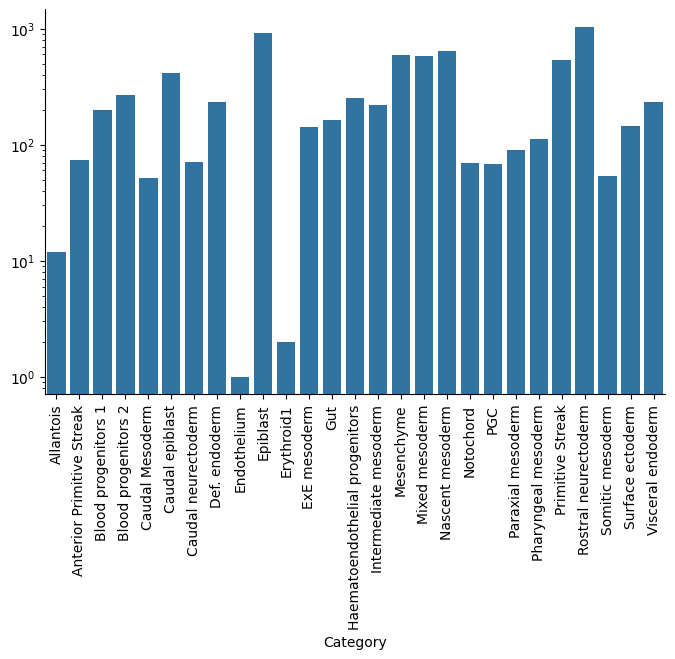

In [7]:
# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=adata.obs["celltype"].value_counts().index, 
            y=adata.obs["celltype"].value_counts().values)


# Customize the plot
plt.xlabel("Category")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.yscale('log')  # Set y-axis to logarithmic scale
sns.despine()  # Remove top and right spines

# Show the plot
plt.show()

In [8]:
adata.obs["celltype"].value_counts()

celltype
Rostral neurectoderm              1036
Epiblast                           924
Nascent mesoderm                   645
Mesenchyme                         597
Mixed mesoderm                     580
Primitive Streak                   538
Caudal epiblast                    418
Blood progenitors 2                268
Haematoendothelial progenitors     254
Def. endoderm                      235
Visceral endoderm                  232
Intermediate mesoderm              220
Blood progenitors 1                201
Gut                                164
Surface ectoderm                   145
ExE mesoderm                       141
Pharyngeal mesoderm                111
Paraxial mesoderm                   90
Anterior Primitive Streak           74
Caudal neurectoderm                 71
Notochord                           69
PGC                                 68
Somitic mesoderm                    54
Caudal Mesoderm                     52
Allantois                           12
Erythroid1      

In [9]:
#cells_OOD = ["Endothelium","Erythroid1", "Allantois", "Caudal Mesoderm" ,"PGC"] 
cells_OOD = ["Endothelium","Erythroid1", "Allantois", "Intermediate mesoderm", "ExE mesoderm", "Pharyngeal mesoderm",  "PGC", "Notochord" , "Anterior Primitive Streak" , "Paraxial mesoderm" , "Caudal neurectoderm" , "Caudal Mesoderm" , "Somitic mesoderm"]             


adata = adata[~adata.obs["celltype"].isin(cells_OOD)].copy()

In [10]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")


In [11]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

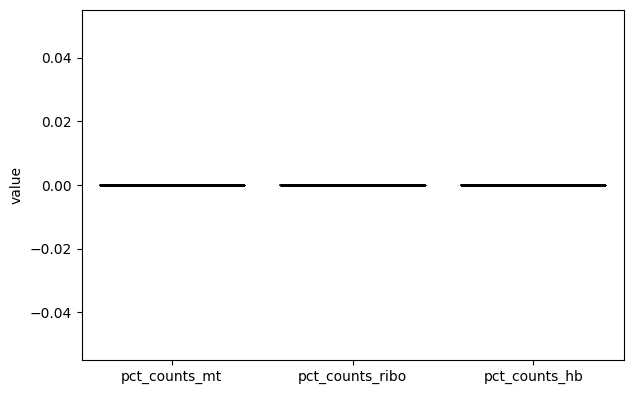

In [12]:
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=False,
)

In [13]:
# Set QC thresholds
mt_threshold = 20  # Percentage of mitochondrial counts
ribo_threshold = 60  # Percentage of ribosomal counts
hb_threshold = 60 # Percentage of hemoglobin counts

# Apply QC filters
filter_condition = (
        (adata.obs["pct_counts_mt"] < mt_threshold) & 
        (adata.obs["pct_counts_ribo"] < ribo_threshold) &
        (adata.obs["pct_counts_hb"] < hb_threshold)
)

adata = adata[filter_condition]

In [14]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

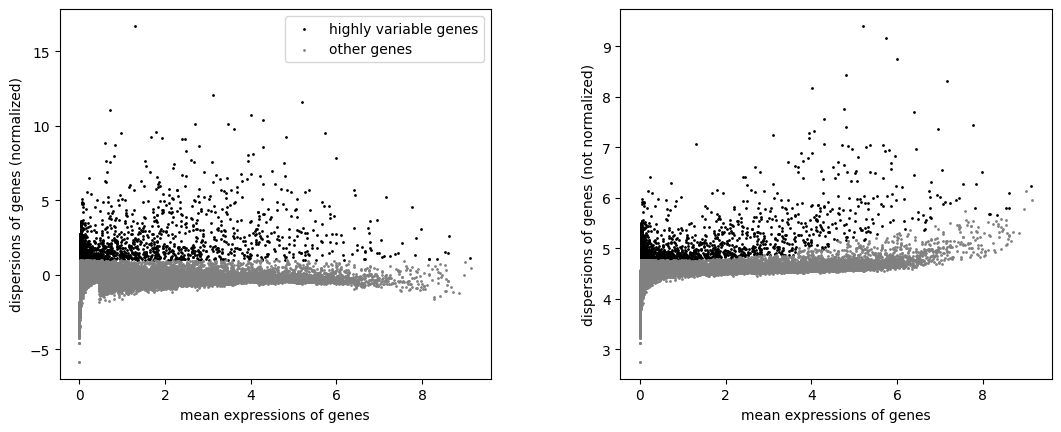

In [15]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [16]:
# Step 1: Select highly variable genes
adata_hvg = adata[:, adata.var['highly_variable']]

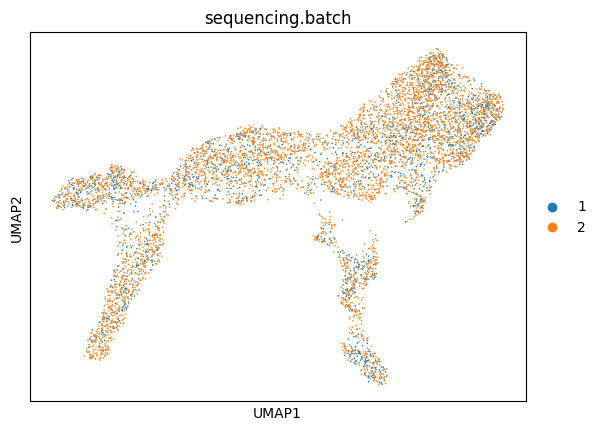

In [17]:
sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)
sc.pl.umap(adata_hvg,color="sequencing.batch",size=5)

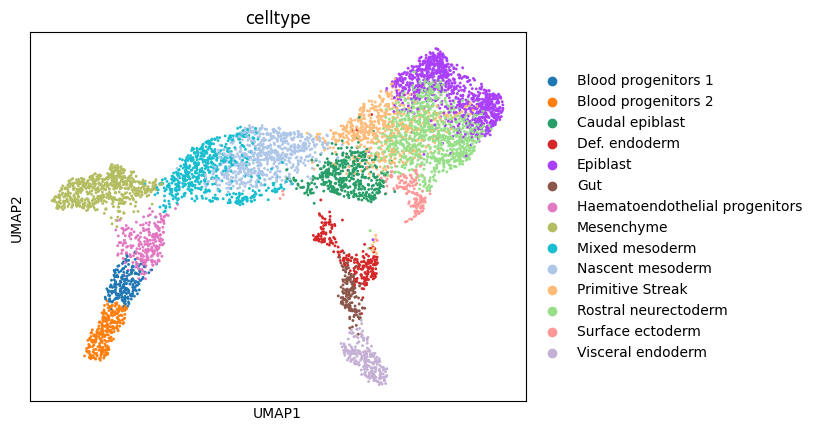

In [18]:
sc.pl.umap(adata_hvg,color="celltype",size=17)

In [19]:
#adata.write("breast_preprocessed.h5ad")

2025-02-14 16:09:40,355 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-14 16:09:41,896 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-14 16:09:41,951 - harmonypy - INFO - Iteration 1 of 50
2025-02-14 16:09:43,073 - harmonypy - INFO - Iteration 2 of 50
2025-02-14 16:09:44,200 - harmonypy - INFO - Iteration 3 of 50
2025-02-14 16:09:44,976 - harmonypy - INFO - Iteration 4 of 50
2025-02-14 16:09:45,727 - harmonypy - INFO - Iteration 5 of 50
2025-02-14 16:09:46,614 - harmonypy - INFO - Iteration 6 of 50
2025-02-14 16:09:46,906 - harmonypy - INFO - Converged after 6 iterations


check integration: 


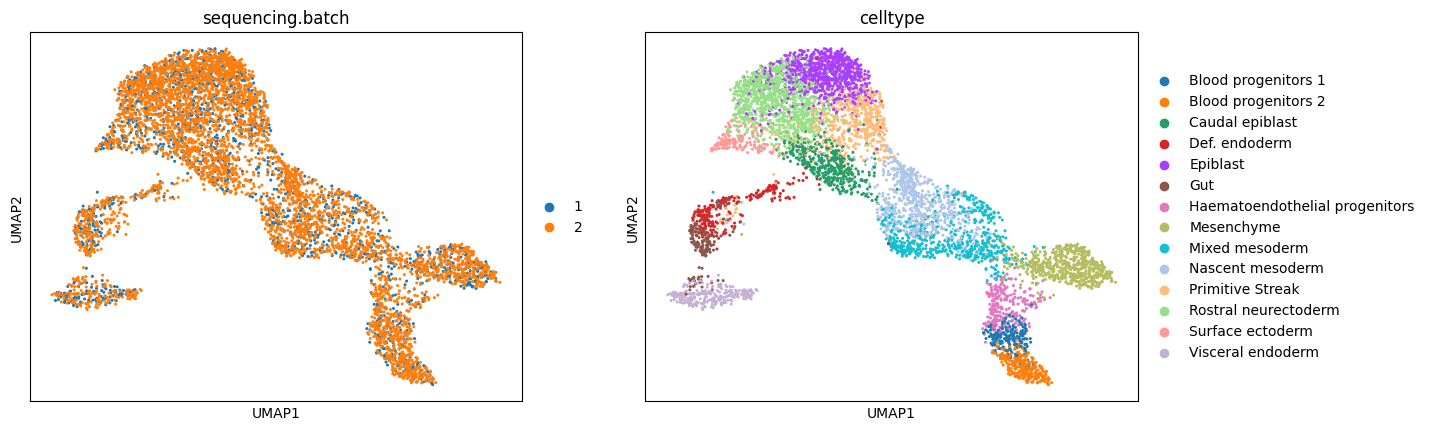

In [20]:



# Apply PCA
sc.pp.pca(adata_hvg)
# Run Harmony
sce.pp.harmony_integrate(adata_hvg, key="sequencing.batch", max_iter_harmony=50, theta=1.5)

print("check integration: ")
sc.pp.neighbors(adata_hvg, use_rep="X_pca_harmony")
sc.tl.umap(adata_hvg)
# Visualize UMAP
sc.pl.umap(adata_hvg, color=["sequencing.batch","celltype" ])

In [21]:


# Step 2: Split datasets by 'surgery'""
adata_ref_1 = adata_hvg[adata_hvg.obs['sequencing.batch'].isin(["1"])].copy()
adata_query_1= adata_hvg[adata_hvg.obs['sequencing.batch'].isin(["2"])].copy()

adata_ref_1.write("gastrulation_reference_1.h5ad")
adata_query_1.write("gastrulation_query_1.h5ad")




In [1]:
import scanpy as sc

In [2]:
adata_ref = sc.read_h5ad("gastrulation_reference_1.h5ad")
adata_query = sc.read_h5ad("gastrulation_query_1.h5ad")

In [5]:
adata_ref

AnnData object with n_obs × n_vars = 1843 × 2000
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'features', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_me

In [6]:
len(adata_ref.obs["celltype"].value_counts())

14

In [8]:

len(adata_query.obs["celltype"].value_counts())

22

In [1]:
import scanpy as sc
import pandas as pd

# Load Experiment 1 datasets
adata_ref1 = sc.read_h5ad("gastrulation_reference_1.h5ad")
adata_query1 = sc.read_h5ad("gastrulation_query_1.h5ad")

# Load Experiment 2 datasets
adata_ref2 = sc.read_h5ad("gastrulation_reference_2.h5ad")
adata_query2 = sc.read_h5ad("gastrulation_query_2.h5ad")

# Get cell type counts for each split
counts_ref1 = adata_ref1.obs["celltype"].value_counts()
counts_query1 = adata_query1.obs["celltype"].value_counts()
counts_ref2 = adata_ref2.obs["celltype"].value_counts()
counts_query2 = adata_query2.obs["celltype"].value_counts()

# Create a union of all cell types observed across splits
cell_types = set(counts_ref1.index).union(counts_query1.index, counts_ref2.index, counts_query2.index)

# Build a DataFrame summarizing the counts
data = []
for ct in sorted(cell_types):
    ref1 = counts_ref1.get(ct, 0)
    query1 = counts_query1.get(ct, 0)
    ref2 = counts_ref2.get(ct, 0)
    query2 = counts_query2.get(ct, 0)
    data.append({
        'Cell Type': ct,
        'Exp1 Ref': ref1,
        'Exp1 Query': query1,
        'Exp2 Ref': ref2,
        'Exp2 Query': query2
    })
df = pd.DataFrame(data)

# Calculate totals for each split
totals = {
    'Exp1 Ref': df['Exp1 Ref'].sum(),
    'Exp1 Query': df['Exp1 Query'].sum(),
    'Exp2 Ref': df['Exp2 Ref'].sum(),
    'Exp2 Query': df['Exp2 Query'].sum()
}

# Loop over rows and print formatted LaTeX table rows with percentages
for idx, row in df.iterrows():
    exp1_ref_perc = row['Exp1 Ref'] / totals['Exp1 Ref'] * 100
    exp1_query_perc = row['Exp1 Query'] / totals['Exp1 Query'] * 100
    exp2_ref_perc = row['Exp2 Ref'] / totals['Exp2 Ref'] * 100
    exp2_query_perc = row['Exp2 Query'] / totals['Exp2 Query'] * 100
    print(f"{row['Cell Type']} & {row['Exp1 Ref']} ({exp1_ref_perc:.1f}\\%) & "
          f"{row['Exp1 Query']} ({exp1_query_perc:.1f}\\%) & {row['Exp2 Ref']} ({exp2_ref_perc:.1f}\\%) & "
          f"{row['Exp2 Query']} ({exp2_query_perc:.1f}\\%) \\\\")

# Print totals row (without percentages)
print(f"\\textbf{{Total}} & {totals['Exp1 Ref']} & {totals['Exp1 Query']} & {totals['Exp2 Ref']} & {totals['Exp2 Query']} \\\\")

Anterior Primitive Streak & 0 (0.0\%) & 0 (0.0\%) & 55 (1.1\%) & 19 (0.9\%) \\
Blood progenitors 1 & 52 (2.8\%) & 149 (3.4\%) & 149 (3.0\%) & 52 (2.6\%) \\
Blood progenitors 2 & 56 (3.0\%) & 212 (4.8\%) & 212 (4.2\%) & 56 (2.8\%) \\
Caudal epiblast & 80 (4.3\%) & 338 (7.7\%) & 338 (6.7\%) & 80 (3.9\%) \\
Caudal neurectoderm & 0 (0.0\%) & 0 (0.0\%) & 59 (1.2\%) & 12 (0.6\%) \\
Def. endoderm & 79 (4.3\%) & 156 (3.6\%) & 156 (3.1\%) & 79 (3.9\%) \\
Epiblast & 283 (15.4\%) & 641 (14.6\%) & 641 (12.7\%) & 283 (14.0\%) \\
ExE mesoderm & 0 (0.0\%) & 0 (0.0\%) & 102 (2.0\%) & 39 (1.9\%) \\
Gut & 56 (3.0\%) & 108 (2.5\%) & 108 (2.1\%) & 56 (2.8\%) \\
Haematoendothelial progenitors & 69 (3.7\%) & 185 (4.2\%) & 185 (3.7\%) & 69 (3.4\%) \\
Intermediate mesoderm & 0 (0.0\%) & 0 (0.0\%) & 179 (3.6\%) & 41 (2.0\%) \\
Mesenchyme & 218 (11.8\%) & 379 (8.6\%) & 379 (7.5\%) & 218 (10.7\%) \\
Mixed mesoderm & 190 (10.3\%) & 390 (8.9\%) & 390 (7.7\%) & 190 (9.4\%) \\
Nascent mesoderm & 160 (8.7\%) & 485 (1